In [18]:
import pandas as pd
import numpy as np
import re
from ast import literal_eval
from scipy.stats import expon
from scipy.stats import gamma
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import fdrcorrection

In [2]:
# imports

In [3]:
#edges = pd.read_csv("/Users/michael/Downloads/neo4j-community-5.12.0/import/test_edges.csv") # Michael
edges = pd.read_csv("/var/lib/neo4j/import/test_edges.csv") # Kyra

In [4]:
edges

,source,target,weight,inter,union
0,ARNTL2,SLCO1B1,1.000000,['NCIH2171_LUNG_amplicon2_ecDNA_1'],['NCIH2171_LUNG_amplicon2_ecDNA_1']
1,COX10,MYOCD,1.000000,['SNU182_LIVER_amplicon1_ecDNA_1'],['SNU182_LIVER_amplicon1_ecDNA_1']
2,DUPD1,SYNPO2L,0.666667,"['PC3_PROSTATE_amplicon1_ecDNA_2', 'EFM19_BREA...","['MFE280_ENDOMETRIUM_amplicon17_ecDNA_1', 'PC3..."
3,B4GALNT2,TPD52L2,0.250000,['HCC1419_BREAST_amplicon1_ecDNA_2'],"['BT474_BREAST_amplicon1_ecDNA_3', 'EFM192A_BR..."
4,ANKRD40CL,NME1-NME2,0.333333,['EFM192A_BREAST_amplicon1_ecDNA_2'],"['EFM192A_BREAST_amplicon1_ecDNA_2', 'HCC202_B..."
...,...,...,...,...,...
118028,TM4SF4,WWTR1,1.000000,['HCC38_BREAST_amplicon3_ecDNA_1'],['HCC38_BREAST_amplicon3_ecDNA_1']
118029,LPCAT3,PHB2,1.000000,['NCIH2171_LUNG_amplicon2_ecDNA_2'],['NCIH2171_LUNG_amplicon2_ecDNA_2']
118030,NT5C1A,MANEAL,0.083333,['NCIH1184_LUNG_amplicon1_ecDNA_1'],"['COLO668_LUNG_amplicon1_ecDNA_1', 'NCIH520_LU..."
118031,NLK,RPL23A,1.000000,['KYSE410_OESOPHAGUS_amplicon3_ecDNA_1'],['KYSE410_OESOPHAGUS_amplicon3_ecDNA_1']


In [5]:
#gene_coords = pd.read_csv("/Users/michael/Downloads/hg38_genes.bed", sep="\t", header=None)
gene_coords = pd.read_csv("/mnt/c/Users/Owner/Downloads/hg38_genes.bed", sep="\t", header=None)

In [6]:
gene_coords

,0,1,2,3,4,5,6
0,chr1,11873,14409,DDX11L1,.,+,NR_046018
1,chr1,14361,29370,WASH7P,.,-,NR_024540
2,chr1,34610,36081,FAM138A,.,-,NR_026818
3,chr1,34610,36081,FAM138F,.,-,NR_026820
4,chr1,34610,36081,FAM138C,.,-,NR_026822
...,...,...,...,...,...,...,...
22993,chrY,24045229,24048014,CDY1,.,-,NM_004680
22994,chrY,24045229,24048014,CDY1B,.,-,NM_001003895
22995,chrY,24183433,24187231,CSPG4P1Y,.,-,NR_001554
22996,chrY,24209966,24214831,GOLGA2P2Y,.,-,NR_001555


In [7]:
# save loc data in dictionary

In [8]:
gene_coords['chr_num'] = gene_coords.apply(lambda row: row[0][-1], axis=1)

In [9]:
locs = {}
for i,row in gene_coords.iterrows():
    locs[row[3]] = (row['chr_num'], int(row[1]))

In [10]:
locs

{'DDX11L1': ('1', 11873),
 'WASH7P': ('1', 14361),
 'FAM138A': ('1', 34610),
 'FAM138F': ('1', 34610),
 'FAM138C': ('1', 34610),
 'OR4F5': ('1', 69090),
 'FAM138D': ('1', 205128),
 'OR4F3': ('1', 450739),
 'OR4F29': ('1', 450739),
 'OR4F16': ('1', 450739),
 'FAM87B': ('1', 817370),
 'FAM41C': ('1', 868070),
 'SAMD11': ('1', 925730),
 'NOC2L': ('1', 944202),
 'KLHL17': ('1', 960583),
 'PLEKHN1': ('1', 966481),
 'PERM1': ('1', 975197),
 'HES4': ('1', 998963),
 'ISG15': ('1', 1013496),
 'AGRN': ('1', 1020119),
 'RNF223': ('1', 1070966),
 'C1orf159': ('1', 1081822),
 'TTLL10': ('1', 1173879),
 'TNFRSF18': ('1', 1203507),
 'TNFRSF4': ('1', 1211339),
 'SDF4': ('1', 1216907),
 'B3GALT6': ('1', 1232236),
 'C1QTNF12': ('1', 1242452),
 'UBE2J2': ('1', 1253911),
 'SCNN1D': ('1', 1280435),
 'ACAP3': ('1', 1292390),
 'SNORD167': ('1', 1304728),
 'PUSL1': ('1', 1308579),
 'INTS11': ('1', 1311584),
 'CPTP': ('1', 1324801),
 'TAS1R3': ('1', 1331279),
 'DVL1': ('1', 1335277),
 'MXRA8': ('1', 1352688),


In [11]:
# only consider co-amplified genes in hg38 refseq gene list (with loc data)

#nodes = pd.read_csv("/Users/michael/Downloads/neo4j-community-5.12.0/import/test_nodes.csv") # Michael
nodes = pd.read_csv("/var/lib/neo4j/import/test_nodes.csv") # Kyra

gene_labels = nodes['label'].tolist()

not_in_refseq = [g for g in gene_labels if g not in locs.keys()]

not_in_refseq

['THRA1',
 'BTR',
 'CTD-2194D22',
 '4',
 'CTD-3080P12',
 '3',
 'CH17-340M24',
 'HGC6',
 'CTD-2350J17',
 '1']

In [12]:
edges['valid_genes'] = edges.apply(lambda row: not(row['source'] in not_in_refseq or row['target'] in not_in_refseq), axis=1)

In [13]:
edges_valid = edges[edges['valid_genes'] == True]

In [14]:
# calculate p_values from theoretical distribution

In [15]:
# models = {
#     'expon': [2, # loc
#               319813.96455938695 # scale
#              ],
#     'gamma': [0.569504897386201, # a
#               1.9999999999999996, # loc
#               304238.4694626314 # scale
#              ],
#     'fatigue_life': [4.087390011411001, # c
#                      -287.3206721470797, # loc
#                      26297.62638444689, # scale
#                     ]
# }

models = {
    'expon': [10017.0, # loc
              797473.0305882352 # scale
             ],
    'gamma': [0.3987543483729932, # a
              1.999999999999, # loc
              1749495.5696758535 # scale
             ],
    'fatigue_life': [4.087390011411001, # c
                     -287.3206721470797, # loc
                     26297.62638444689, # scale
                    ]
}

In [19]:
def distance(a, b):
    
    if locs[a][0] != locs[b][0]:
        return 'N/A'# f"{locs[a][0]}, {locs[b][0]}"
    return abs(locs[a][1] - locs[b][1])

def p_val(a, b, model='gamma'):
    params = models[model]
    if model == 'expon':
        d = distance(a, b)
        if not type(d) is str:
            cdf = expon.cdf(d, loc=params[0], scale=params[1])
            return 1-cdf
    elif model == 'gamma':
        d = distance(a, b)
        if not type(d) is str:
            cdf = gamma.cdf(d, a=params[0], loc=params[1], scale=params[2])
            return 1-cdf
    return 'N/A'

In [20]:
p_val('ARNTL2','ARNTL2')

np.float64(1.0)

In [21]:
edges_valid['p_val'] = edges_valid.apply(lambda row: p_val(row['source'], row['target']), axis=1)
edges_valid['distance'] = edges_valid.apply(lambda row: distance(row['source'], row['target']), axis=1)

/tmp/ipykernel_3379/1120929523.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_valid['p_val'] = edges_valid.apply(lambda row: p_val(row['source'], row['target']), axis=1)
/tmp/ipykernel_3379/1120929523.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_valid['distance'] = edges_valid.apply(lambda row: distance(row['source'], row['target']), axis=1)


In [22]:
# plot p_val dist

In [23]:
p_values = edges_valid[edges_valid['p_val'] != 'N/A']['p_val'].tolist()

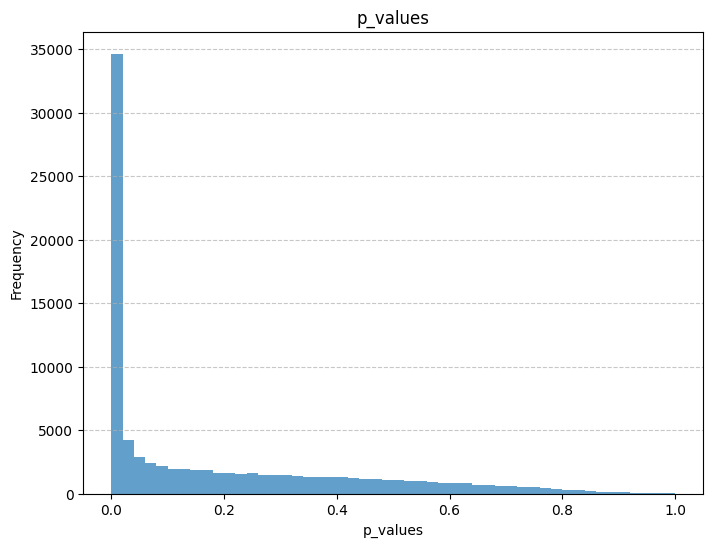

In [24]:
plt.figure(figsize=(8, 6))
plt.hist(p_values, bins=50, alpha=0.7)
plt.title("p_values")
plt.xlabel("p_values")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [25]:
# Q-values
corrected = fdrcorrection(p_values, alpha = 0.05)

In [26]:
corrected[1]

array([1.66751927e-02, 2.68620059e-01, 2.70349539e-01, ...,
       2.03660784e-01, 4.22694019e-01, 6.57078685e-06], shape=(88255,))

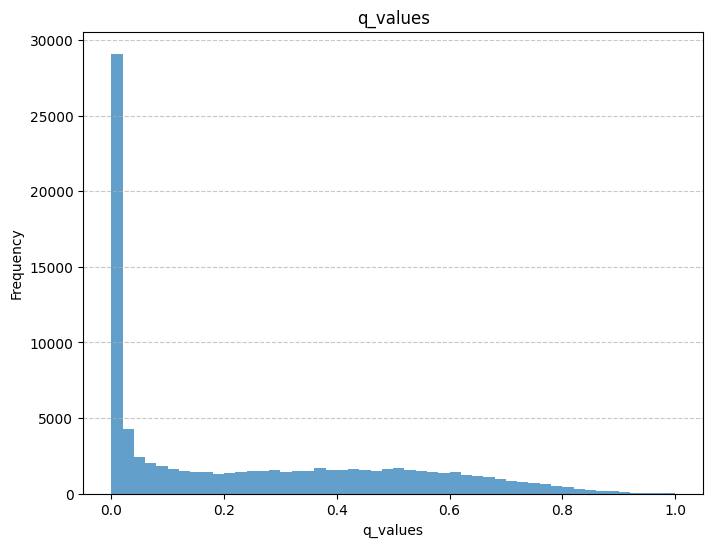

In [27]:
plt.figure(figsize=(8, 6))
plt.hist(corrected[1], bins=50, alpha=0.7)
plt.title("q_values")
plt.xlabel("q_values")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [28]:
# plot gene coamplification distances dist

In [29]:
distances = edges_valid[edges_valid['distance'] != 'N/A']['distance'].tolist()

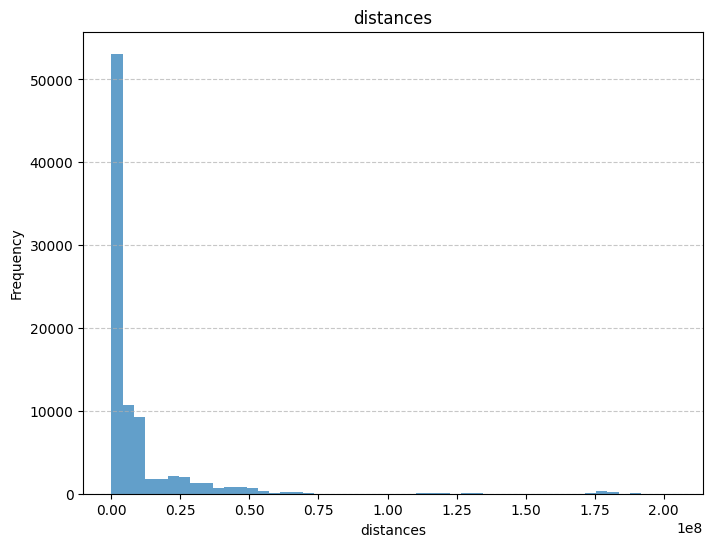

In [30]:
plt.figure(figsize=(8, 6))
plt.hist(distances, bins=50, alpha=0.7)
plt.title("distances")
plt.xlabel("distances")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/tmp/ipykernel_3379/4083883184.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


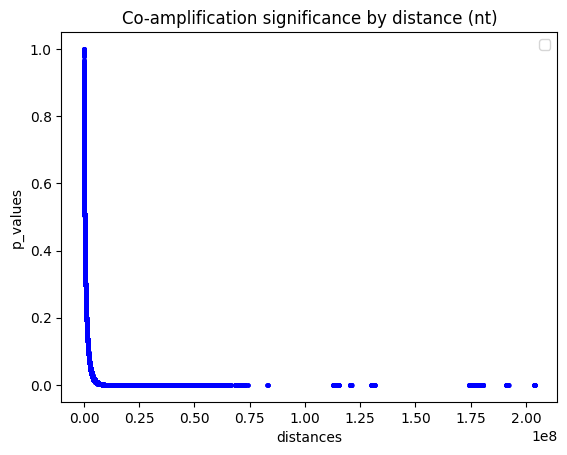

In [31]:
# Create the scatter plot
plt.scatter(distances, p_values, color='blue', s=5)

# Add labels, title, and legend
plt.xlabel('distances')
plt.ylabel('p_values')
plt.title('Co-amplification significance by distance (nt)')
plt.legend()

# Show the plot
plt.show()

/tmp/ipykernel_3379/2053829836.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


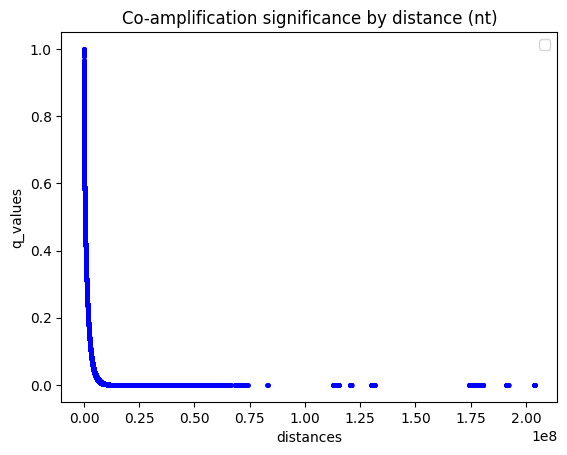

In [32]:
# Create the scatter plot
plt.scatter(distances, corrected[1], color='blue', s=5)

# Add labels, title, and legend
plt.xlabel('distances')
plt.ylabel('q_values')
plt.title('Co-amplification significance by distance (nt)')
plt.legend()

# Show the plot
plt.show()